# Parsing and Recombining Inputs

In this chapter, we use grammars to parse and decompose inputs, allowing us to recombine them arbitrarily.  \todo{Work in progress.}

**Prerequisites**

* You should have read the [chapter on grammars](Grammars.ipynb).

In [1]:
import fuzzingbook_utils

In [2]:
from Grammars import EXPR_GRAMMAR, START_SYMBOL

In [3]:
from GrammarFuzzer import display_tree

In [4]:
import functools
import re

RE_NONTERMINAL = re.compile(r'(<[a-zA-Z_]*>)')

class PEGParser:
    def __init__(self, grammar):
        def split(rule): return tuple(s for s in re.split(RE_NONTERMINAL, rule) if s)
        self.grammar = {k:[split(l) for l in rules] for k,rules in grammar.items()}

    def literal_match(self, part, text, cursor):
        return (cursor + len(part), (part, [])) if text[cursor:].startswith(part) else (cursor, None)

    # memoize repeated calls.
    @functools.lru_cache(maxsize=None)
    def unify_key(self, key, text, cursor=0):
        rules = self.grammar[key]
        # make a generator for matching rules. We dont want a list because
        # we want to be lazy and evaluate only until the first matching
        rets = (self.unify_line(rule, text, cursor) for rule in rules)
        # return the first non null (matching) rule's cursor and res
        cursor, res = next((ret for ret in rets if ret[1] is not None), (cursor, None))
        return (cursor, (key, res) if res is not None else None)

    def unify_line(self, parts, text, cursor):
        def is_symbol(v): return v[0] == '<'

        results = []
        for part in parts:
            # get the matcher function
            matcher = (self.unify_key if is_symbol(part) else self.literal_match)
            # compute the cursor, and the result from it.
            cursor, res = matcher(part, text, cursor)
            if res is None: return (cursor, None)
            results.append(res)
        return cursor, results

In [5]:
def parse(text, grammar, start_symbol=START_SYMBOL):
    def readall(fn): return ''.join([f for f in open(fn, 'r')]).strip()

    result = PEGParser(grammar).unify_key(start_symbol, text)
    return result

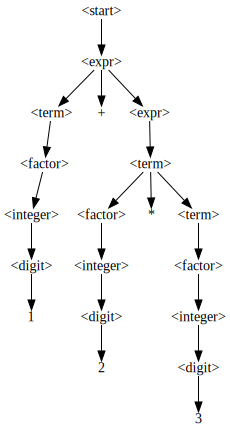

In [6]:
cursor, tree = parse("1 + 2 * 3", EXPR_GRAMMAR)
display_tree(tree)

## _Section 4_

\todo{Add}

## Lessons Learned

* _Lesson one_
* _Lesson two_
* _Lesson three_

## Next Steps

_Link to subsequent chapters (notebooks) here, as in:_

* [use _mutations_ on existing inputs to get more valid inputs](MutationFuzzer.ipynb)
* [use _grammars_ (i.e., a specification of the input format) to get even more valid inputs](Grammars.ipynb)
* [reduce _failing inputs_ for efficient debugging](Reducing.ipynb)


## Exercises

Close the chapter with a few exercises such that people have things to do.  In Jupyter Notebook, use the `exercise2` nbextension to add solutions that can be interactively viewed or hidden:

* Mark the _last_ cell of the exercise (this should be a _text_ cell) as well as _all_ cells of the solution.  (Use the `rubberband` nbextension and use Shift+Drag to mark multiple cells.)
* Click on the `solution` button at the top.

(Alternatively, just copy the exercise and solution cells below with their metadata.)

### Exercise 1

_Text of the exercise_

In [7]:
# Some code that is part of the exercise
pass

_Some more text for the exercise_

_Some text for the solution_

In [8]:
# Some code for the solution
2 + 2

4

_Some more text for the solution_

### Exercise 2

_Text of the exercise_

_Solution for the exercise_